#Connect to my drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
os.chdir("./drive/My Drive/")
print(os.getcwd())

/content/drive/My Drive


#Select tensorflow's version

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Install libraries

In [ ]:
!pip install pydicom
!pip install SimpleITK
!pip install medpy

     |████████████████████████████████| 35.5MB 97kB/s 
     |████████████████████████████████| 42.5MB 72kB/s 
     |████████████████████████████████| 153kB 2.8MB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp36-cp36m-linux_x86_64.whl size=753423 sha256=0a657dc7163720d51612fdc8dfdd2a8a7b6ab1d0438ff8165ffc21747d7ed4b0
  Stored in directory: /root/.cache/pip/wheels/8c/c9/9c/2c6281c7a72b9fb1570862a4f028af7ce38405008354fbf870
Successfully built medpy


#Import libraries

In [ ]:
#load data
import pydicom as dcm
import natsort
import glob, os
import pandas as pd
import numpy as np
from medpy.io import load
#plot image
import matplotlib.pyplot as plt
#preprocessing
from skimage.transform import resize
from scipy import ndimage
from scipy.ndimage import binary_fill_holes
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte
import skimage
from skimage import io
#keras
import warnings
warnings.filterwarnings("ignore")
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D,UpSampling2D,BatchNormalization, MaxPooling2D, Conv2DTranspose, Activation,Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau,CSVLogger
from keras.losses import binary_crossentropy
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
import tensorflow as tf


#Create function:

1.   Load data
2.   Preprocessing
3.   Plot data




#1. Preprocessing function

In [ ]:
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()

def get_size_crop(input_img,mask,min_width,min_height):
  col_maxes = np.max(mask, axis=0) # a row
  row_maxes = np.max(mask, axis=0)# a column
  nonzero_colmaxes = np.nonzero(col_maxes)[1]
  nonzero_rowmaxes = np.nonzero(row_maxes)[0]
  x1, x2 = min(nonzero_colmaxes), max(nonzero_colmaxes)
  y1, y2 = min(nonzero_rowmaxes), max(nonzero_rowmaxes)
  width = x2-x1
  height= y2-y1
  # MIN_WIDTH = 180
  # MIN_HEIGHT = 120
  MIN_WIDTH = min_width
  MIN_HEIGHT = min_height
  x_pad = (MIN_WIDTH - width) / 2 if width < MIN_WIDTH else 0
  y_pad = (MIN_HEIGHT - height)/2 if height < MIN_HEIGHT else 0

  x1 = max(0, x1-x_pad)
  x2 = min(input_img.shape[2], x2+x_pad)
  y1 = max(0, y1-y_pad)
  y2 = min(input_img.shape[1], y2+y_pad)
  return x1,x2,y1,y2
def get_size_crop_ver2(image,label,min_width,min_height):
  col_maxes = np.max(label, axis = 1)
  row_maxes = np.max(label,axis = 0)
  nonzero_colmaxes = np.nonzero(col_maxes)[0]
  nonzero_rowmaxes = np.nonzero(row_maxes)[0]
  # print(nonzero_colmaxes)
  x1,x2 = min(nonzero_colmaxes), max(nonzero_colmaxes)
  y1,y2 = min(nonzero_rowmaxes),max(nonzero_rowmaxes)
  width =x2-x1
  height =y2-y1

  MIN_WIDTH = min_width
  MIN_HEIGHT = min_height
  x_pad = (MIN_WIDTH - width) / 2 if width < MIN_WIDTH else 0
  y_pad = (MIN_HEIGHT  - height) / 2 if height < MIN_HEIGHT else 0

  x1= max(0,x1-x_pad)
  x2= min(image.shape[1],x2+x_pad)  
  y1 = max(0,y1-y_pad)
  y2 = min(image.shape[0], y2+y_pad)
  return x1,x2,y1,y2
def crop_image_iterates(img, label, size ):
  temp_img = img
  temp_label = label
  # create result
  new_img = np.zeros((0,256,256,1))
  new_label = np.zeros((0,256,256,1))
  for i in range(temp_img.shape[0]):
    width = 256
    height = 256
    while width >= 50 and height >= 50:
      min_width = width - size[0]
      min_height = height - size[1]
      if min_width < 50 or min_height < 50:
        min_width = 50
        min_height = 50
      #crop image
      x1,x2,y1,y2 = map(int,get_size_crop_ver2(temp_img[i,:,:,0],temp_label[i,:,:,0],min_width,min_height))
      image_i = temp_img[i,x1:x2+1,y1:y2+1,0]
      label_i = temp_label[i,x1:x2+1,y1:y2+1,0]
      image_i = image_i[np.newaxis,:,:,np.newaxis]
      label_i = label_i[np.newaxis,:,:,np.newaxis]
      image_i = resize(image_i,(1,256,256,1),preserve_range=False)
      label_i = resize(label_i,(1,256,256,1),preserve_range=False)
      
      new_img = np.concatenate((new_img,image_i),axis=0)
      new_label = np.concatenate((new_label,label_i), axis=0)

      width = width - size[0]
      height = height - size[1]
  a = np.count_nonzero(new_label)
  print(a)
  return new_img,new_label

def resize_image(data):
  data = resize(data,(data.shape[0],256,256),preserve_range=False)
  return data
def padding_image(range,img):
  
  pad_img = np.ones([img.shape[0],img.shape[1]+2*range, img.shape[2]+2*range])*img[0,0,0]
  if img.ndim == 4:
    pad_img = pad_img[:,:,:,np.newaxis]
  pad_img[:,range:-range,range:-range] = img
  img = pad_img
  return img
def padding_and_resize(size,img):
  img = padding_image(size,img)
  img = resize_image(img)
  return img

import cv2

def remove_empty(data,mask):
  i = 0
  t = 0
  while t == 0:
    t = np.count_nonzero(mask[i,:,:,0])
    i += 1
  rs = np.zeros([0,data.shape[1],data.shape[2],data.shape[3]])
  rs_mask = np.zeros([0,data.shape[1],data.shape[2],data.shape[3]])
  i += 1
  while i < data.shape[0]:
    t = np.count_nonzero(mask[i,:,:,0])
    if t == 0:
      i += 1
    else:
      j = i
      while t != 0:
        j+=1
        t = np.count_nonzero(mask[j,:,:,0])
      rs_i = data[i:j,:,:,:]
      rs_mask_i = mask[i:j,:,:,:]
      rs = np.concatenate((rs,rs_i),axis=0)
      rs_mask =np.concatenate((rs_mask,rs_mask_i),axis=0)
      i += (j-i)
  return rs,rs_mask

def add_noise(image,label,noise):
  temp_img = image/512.0
  image = skimage.util.random_noise(temp_img,mode=noise,var = 0.1**2)
  return image, label
def noise(image,label,mode):
  noise_image = np.zeros((image.shape[0],image.shape[1],image.shape[2],image.shape[3]))
  noise_label = np.zeros((image.shape[0],image.shape[1],image.shape[2],image.shape[3]))
  for i in range(image.shape[0]):
    noise_image[i,:,:,:], noise_label[i,:,:,:] = add_noise(image[i,:,:,:],label[i,:,:,:],mode[0])
  for i in range(1,len(mode)):
    noise_image_i = np.zeros((image.shape[0],image.shape[1],image.shape[2],image.shape[3]))
    noise_label_i = np.zeros((image.shape[0],image.shape[1],image.shape[2],image.shape[3]))
    for j in range(noise_image.shape[0]):
      noise_image_i[j,:,:,:], noise_label_i[j,:,:,:] = add_noise(image[j,:,:,:],label[j,:,:,:],mode[i])
    noise_image = np.concatenate((noise_image,noise_image_i),axis=0)
    noise_label = np.concatenate((noise_label,noise_label_i),axis=0)
  return noise_image,noise_label
def normalization_mask(mask):
  mask[mask > 0.5] = 1
  mask[mask <=0.5] = 0
  nor_mask = img_as_ubyte(mask)
  nor_mask = binary_fill_holes(nor_mask).astype(np.uint8)
  print(np.count_nonzero(nor_mask))
  return nor_mask  
  
def augmentation(input,mask):
  x,y = input,mask
  aug_input,aug_mask = input,mask
  size = [10,15]
  select_noise = ["gaussian"]
  crop_input, crop_label = crop_image_iterates(input,mask,size)
  noise_input,noise_mask = noise(x,y,select_noise)  
  rotate_input = ndimage.rotate(input,90,axes=(1,2),reshape=False)
  rotate_mask = ndimage.rotate(mask,90,axes=(1,2),reshape=False)
  aug_input = np.concatenate((aug_input,crop_input,noise_input,rotate_input),axis=0)
  aug_mask = np.concatenate((aug_mask,crop_label,noise_mask,rotate_mask),axis=0)
  return aug_input,aug_mask

#2. Load Data function

In [ ]:
def read_nifti_files(filename):
  image = sitk.ReadImage(filename)  # Use ITK to read the image
  image = sitk.GetArrayFromImage(image)  # Turn ITK image object into a numpy array
  return image

def read_dicom_files(directory,filespattern):
  print(directory)
  if not os.path.exists(directory) or not os.path.isdir(directory):
    raise ValueError("Given directory does not exist or is a file : "+str(directory))
  lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filespattern)))
  # Get ref file
  RefDs = dcm.read_file(lstFilesDCM[0])
  # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
  ConstPixelDims = (len(lstFilesDCM),int(RefDs.Rows), int(RefDs.Columns))
  # The array is sized based on 'ConstPixelDims'
  ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
  for filenameDCM in lstFilesDCM:
      # read the file
      ds = dcm.read_file(filenameDCM)
      # store the raw image data
      ArrayDicom[lstFilesDCM.index(filenameDCM),:, : ] = ds.pixel_array
  return ArrayDicom

def read_mha_files(directory,name_image):
  if not os.path.exists(directory) or not os.path.isdir(directory):
    raise ValueError("Given directory does not exist or is a file : "+str(directory))
  image_data,image_header = load(os.path.join(directory,name_image))
  return image_data

def unit_load(nameImage, arg):
  basedir = './new_data_preprocessing'
  dir2='./data_preprocessing'
  train = read_nifti_files(os.path.join(basedir, str(arg[0])+str(nameImage)))

  train = train.astype('float32')
  y_train = read_nifti_files(os.path.join(dir2, str(arg[0])+'_tumorMask.nii'))
  liver_train = read_nifti_files(os.path.join(dir2,str(arg[0])+'_targetMask.nii'))
  #Flip + rotate img
  train = ndimage.rotate(train,180,axes=(1,2),reshape=True)
  y_train = ndimage.rotate(y_train,180,axes=(1,2),reshape=True)
  liver_train = ndimage.rotate(liver_train,180,axes=(1,2),reshape=True)

  #padding and resize
  train = padding_and_resize(33,train)
  y_train = padding_and_resize(33,y_train)
  liver_train = padding_and_resize(33,liver_train)
  #remove background

  train = np.multiply(train,np.clip(liver_train,0,1))
  # crop img
  a,b,c,d = map(int,crop_liver(train,liver_train,100,100))
  train = train[:,c:d+1,a:b+1]
  y_train = y_train[:,c:d+1,a:b+1]
  
  train = padding_and_resize(33,train)
  y_train = padding_and_resize(33,y_train)
  for i in range(1,len(arg)):
    
      train_1 = read_nifti_files(os.path.join(basedir, str(arg[i])+str(nameImage)))

      train_1 = train_1.astype('float32')
      y_train_1 = read_nifti_files(os.path.join(dir2, str(arg[i])+'_tumorMask.nii'))
      liver_train_1 = read_nifti_files(os.path.join(dir2,str(arg[i])+'_targetMask.nii'))
      
      #Flip + rotate img
      train_1 = ndimage.rotate(train_1,180,axes=(1,2),reshape=True)
      liver_train_1 = ndimage.rotate(liver_train_1,180,axes=(1,2),reshape=True)
      y_train_1 = ndimage.rotate(y_train_1,180,axes=(1,2),reshape=True)

      #padding and resize
      train_1 = padding_and_resize(33,train_1)
      y_train_1 = padding_and_resize(33,y_train_1)
      liver_train_1 = padding_and_resize(33,liver_train_1)
      #remove background
      train_1 = np.multiply(train_1,np.clip(liver_train_1,0,1))
      # crop img
      a,b,c,d = map(int,crop_liver(train_1,liver_train_1,100,100))
      train_1 = train_1[:,c:d+1,a:b+1]
      y_train_1 = y_train_1[:,c:d+1,a:b+1]
     
      train_1 = padding_and_resize(33,train_1)
      y_train_1 = padding_and_resize(33,y_train_1)
      
      train = np.concatenate((train, train_1), axis=0)
      y_train = np.concatenate((y_train, y_train_1), axis=0)
  
  return train, y_train

def load_train():
  train_i = np.asarray([1,4,7,9,13,14,16,17,25,26,28,29,30,31])
  # train_i = np.asarray([14,31])

  train_x, train_y = unit_load(nameImage='_inputImage_1.nii', arg=train_i)
  train_x = train_x[:,:,:, np.newaxis]
  train_y = train_y[:,:,:, np.newaxis]
  print("Load train completed!")
  return train_x,train_y

# 3,5,6,7,8,10,11,12,13,14,15,17,18,21,22,23,24,25,26,29,30
def load_test():
  test_i = np.asarray([2,9,27])
      
  test_x, test_y = unit_load(nameImage='_inputImage_1.nii', arg=test_i)
  test_x = test_x[:,:,:, np.newaxis]
  test_y = test_y[:,:,:, np.newaxis]
  print("Load test completed!")
  return test_x,test_y

#Using function to load data, preprocessing and plot

In [ ]:
train_x,train_y = load_train()
test_x,test_y = load_test()

Load train completed!
Load test completed!


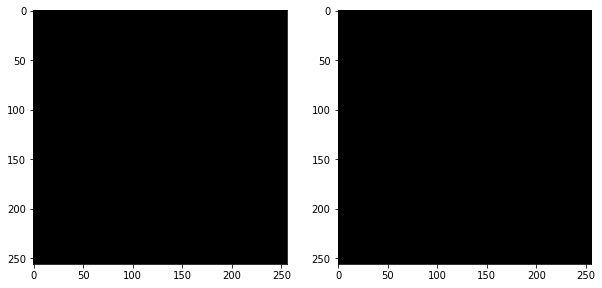

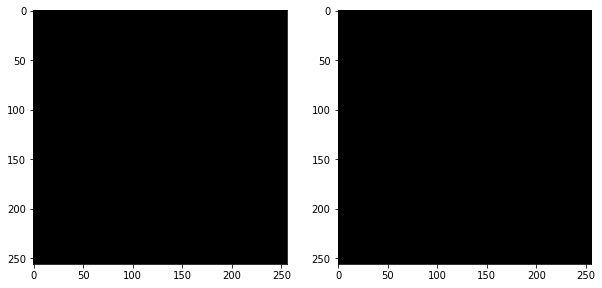

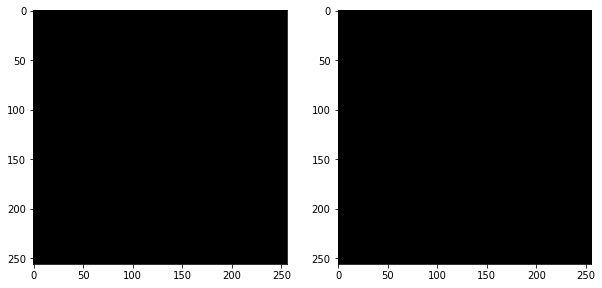

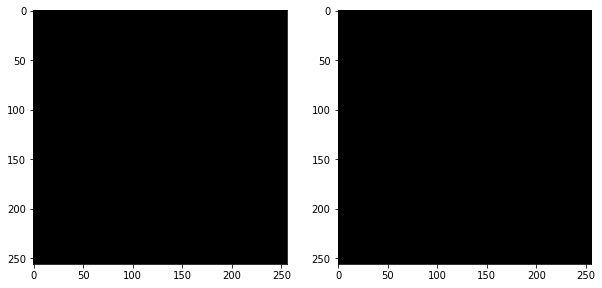

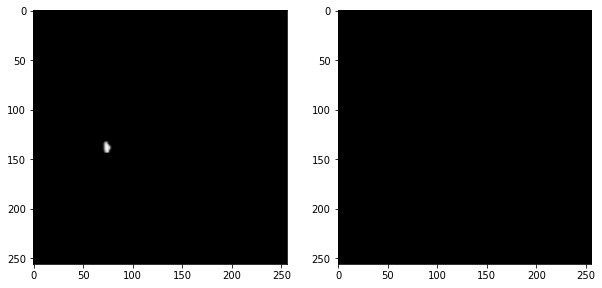

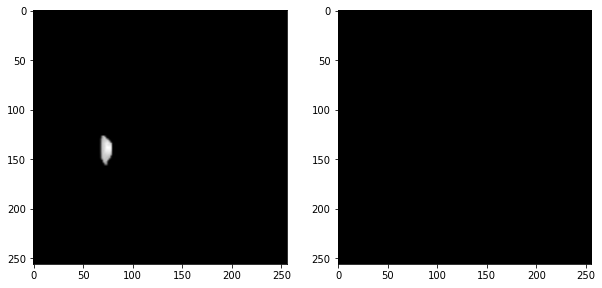

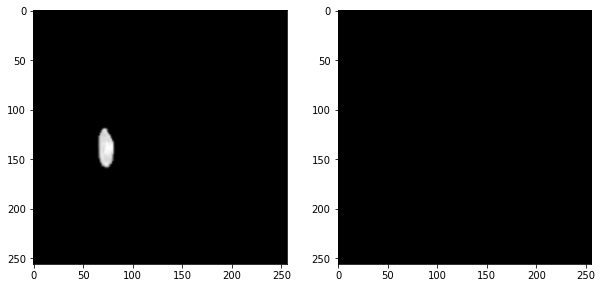

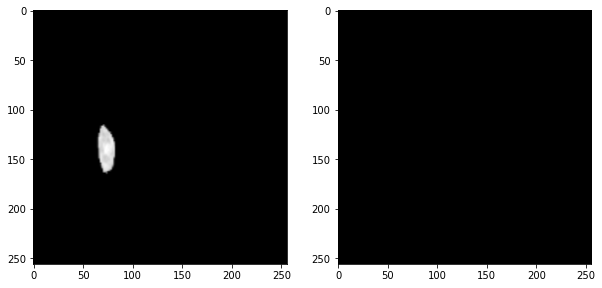

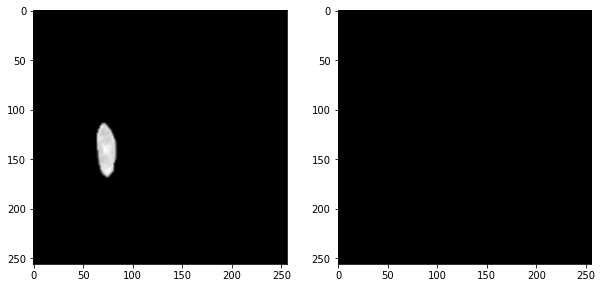

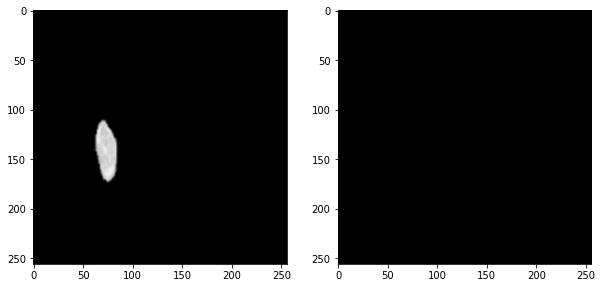

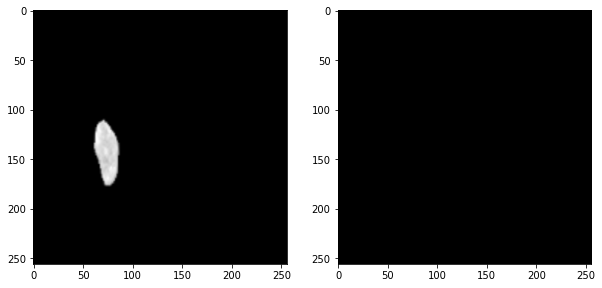

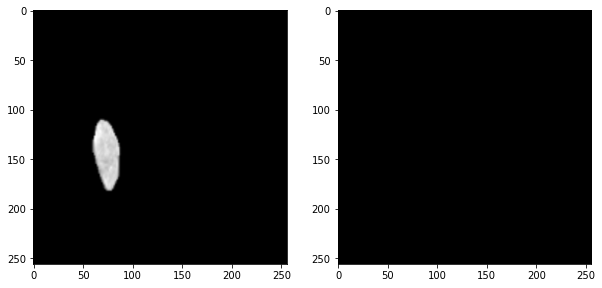

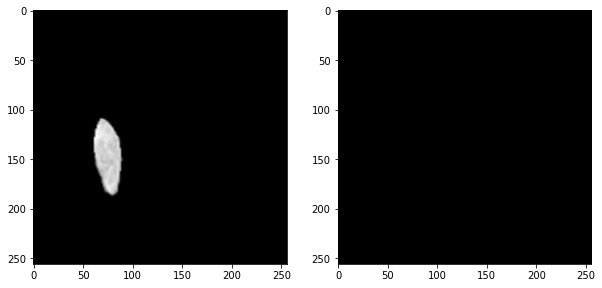

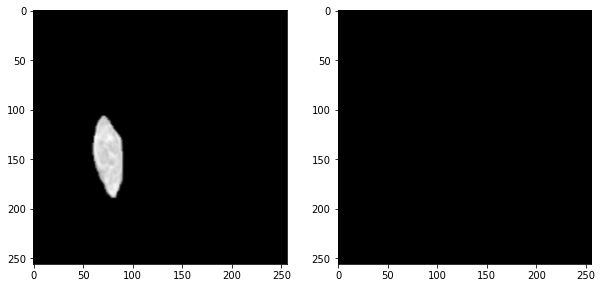

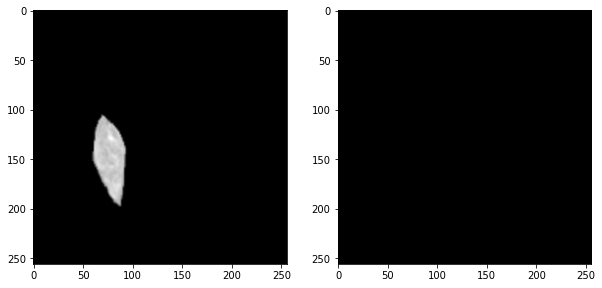

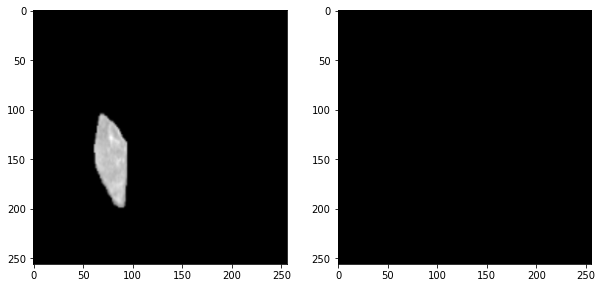

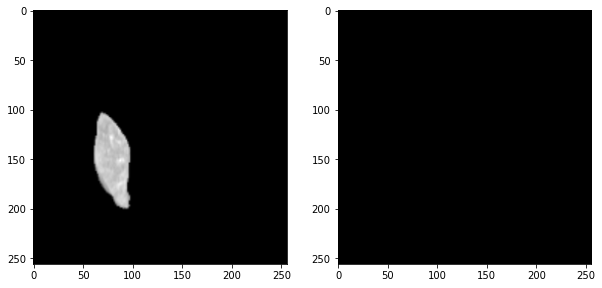

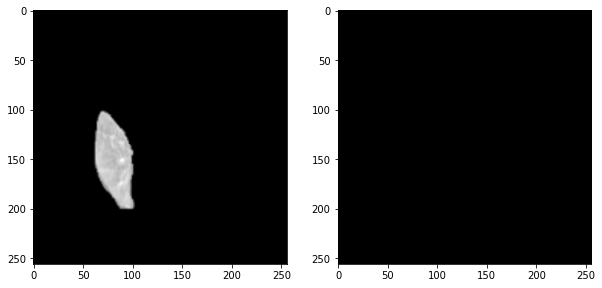

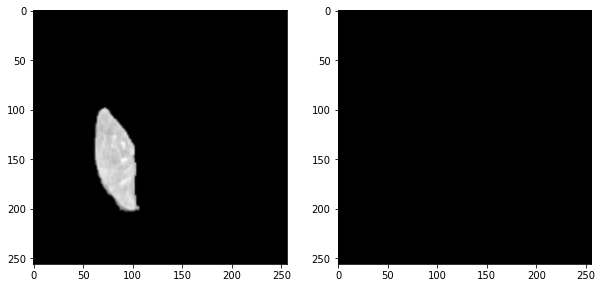

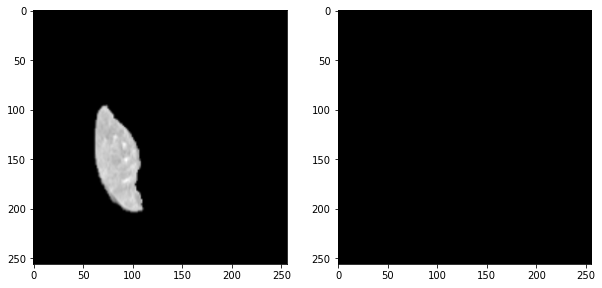

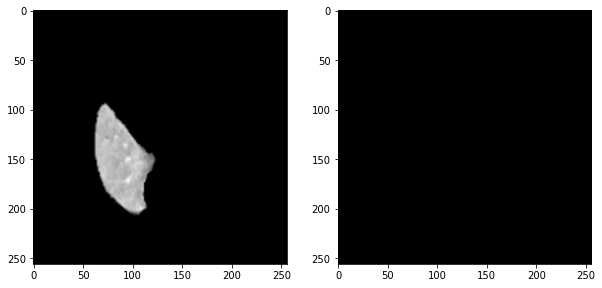

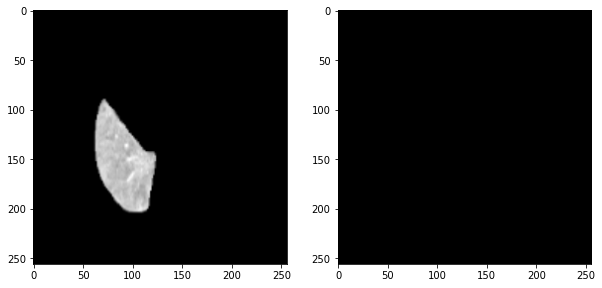

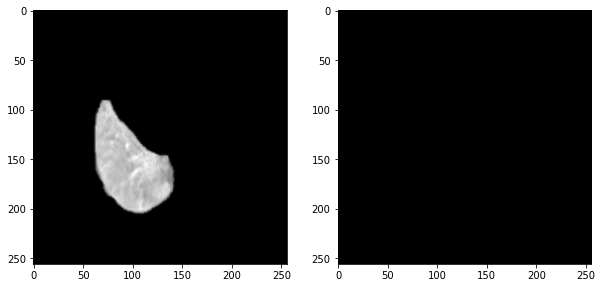

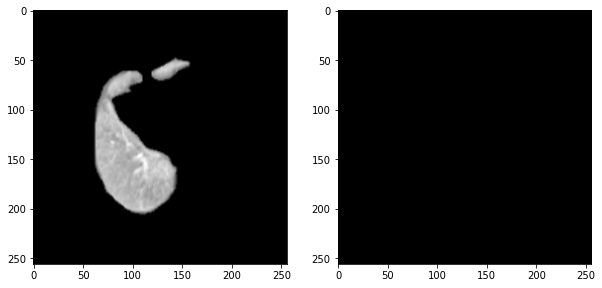

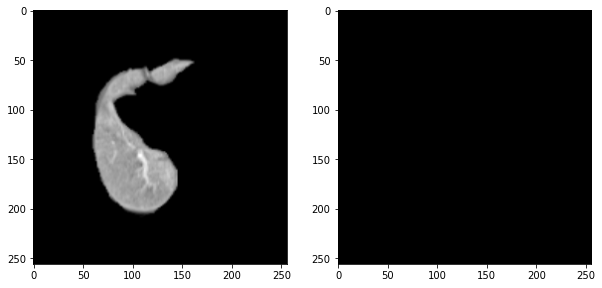

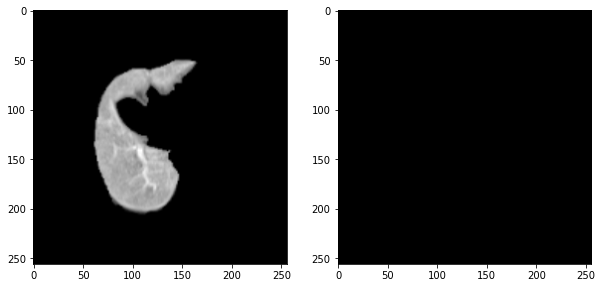

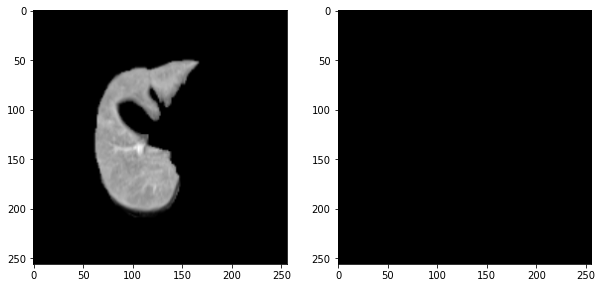

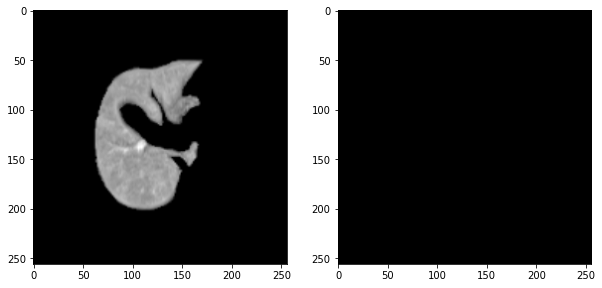

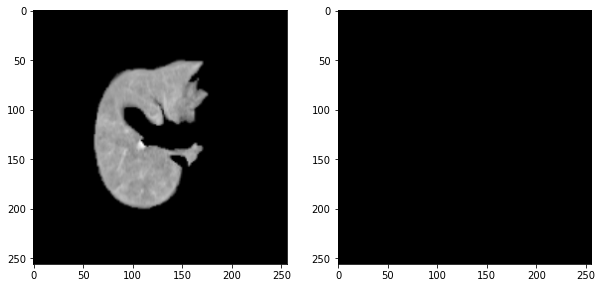

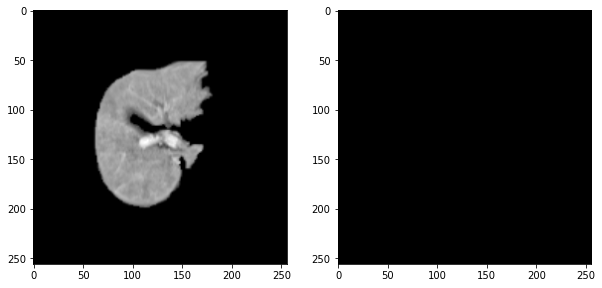

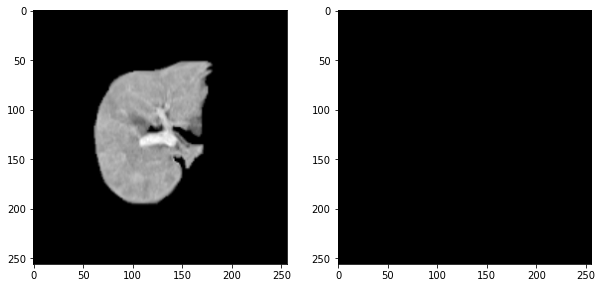

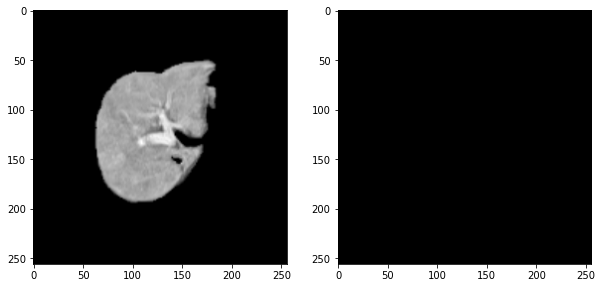

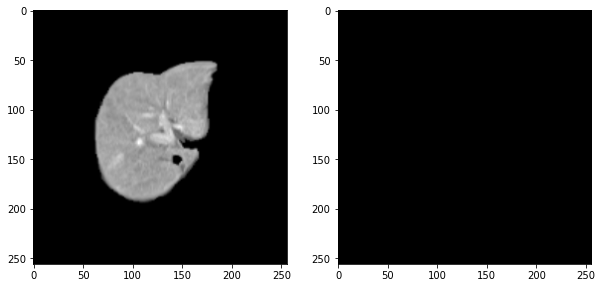

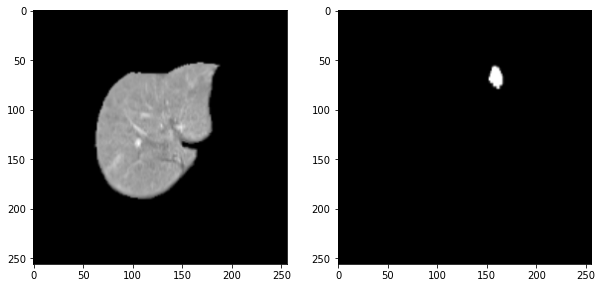

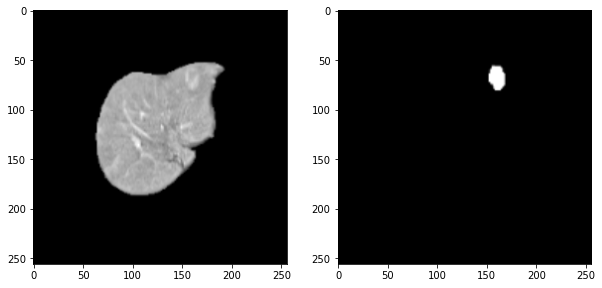

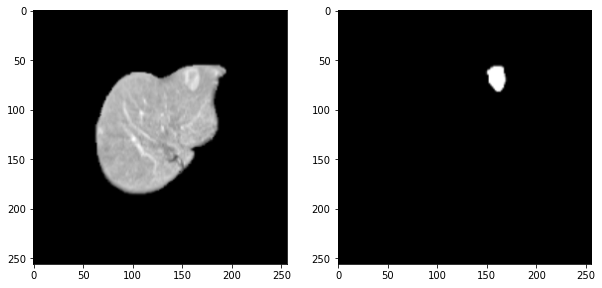

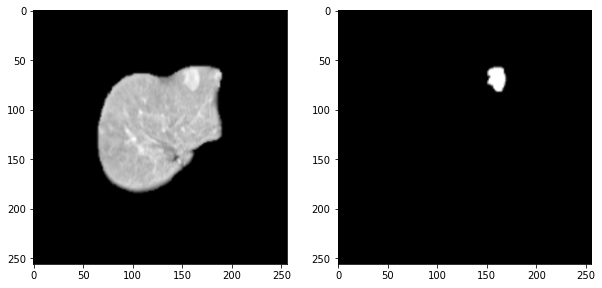

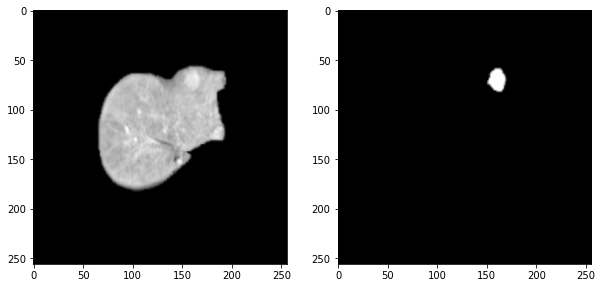

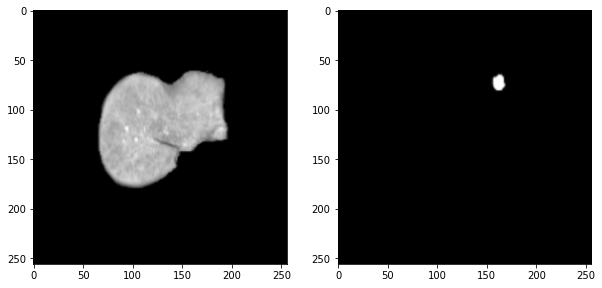

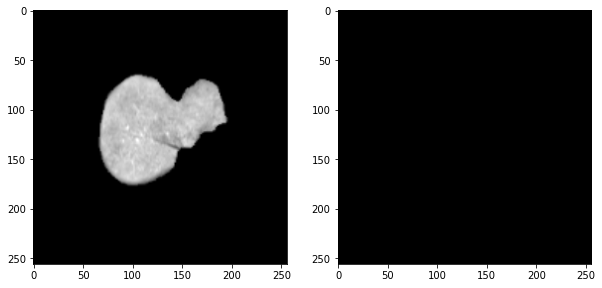

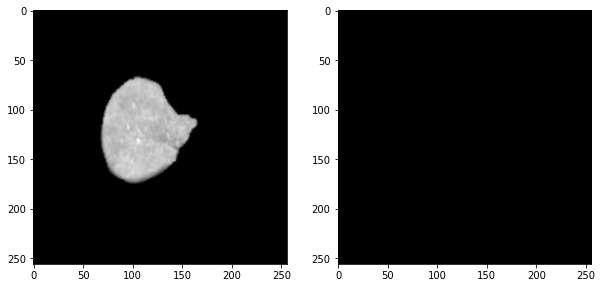

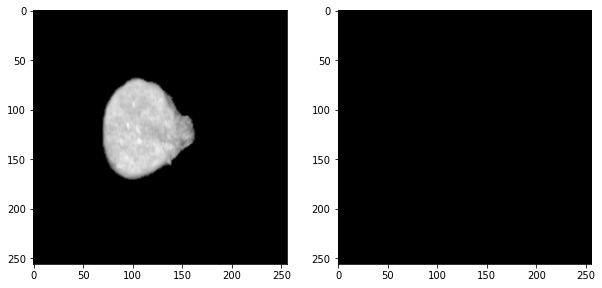

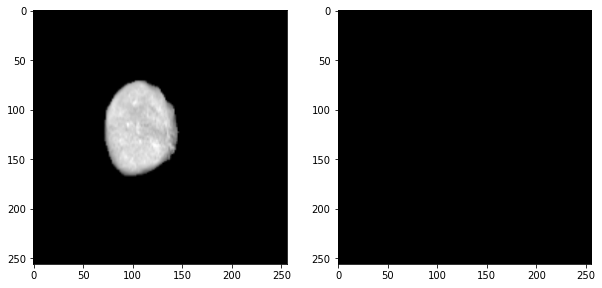

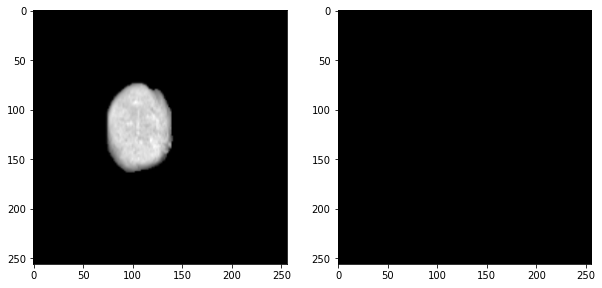

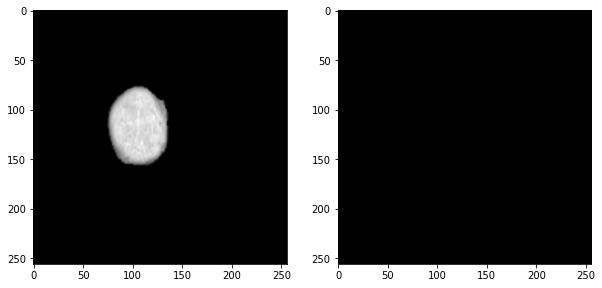

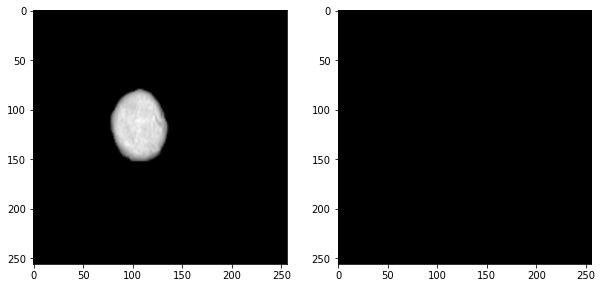

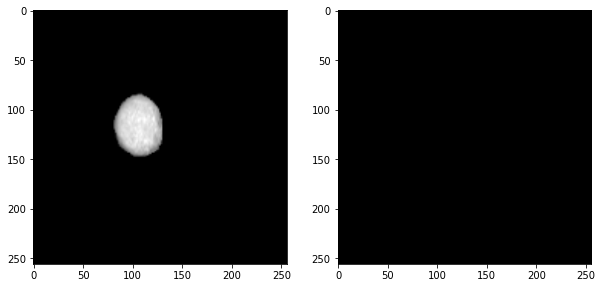

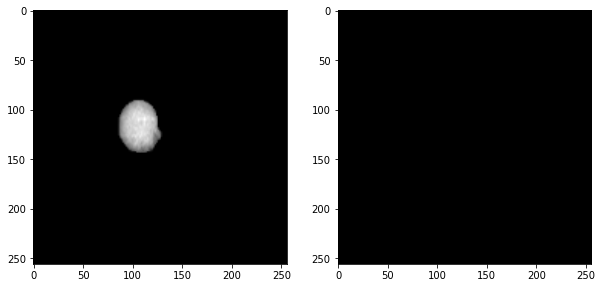

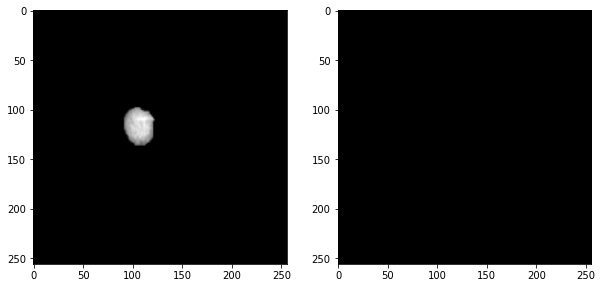

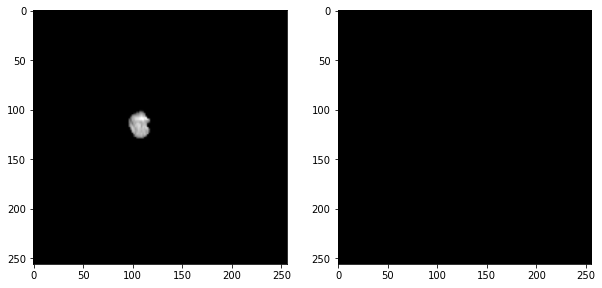

In [ ]:
for i in range(50):
  imshow(train_x[i,:,:,0],train_y[i,:,:,0])

In [ ]:
input_data,mask_data = remove_empty(train_x,train_y)

In [ ]:
train_p, test_p, train_mask_p, test_mask_p = train_test_split(input_data,mask_data, test_size=0.3,random_state = 16)

print(train_p.shape,train_mask_p.shape,train_p.dtype)

(104, 256, 256, 1) (104, 256, 256, 1) float64


In [ ]:
print(train_p.dtype,train_mask_p.dtype,test_p.dtype,test_mask_p.dtype)

float64 float64 float64 float64


In [ ]:
train_p,train_mask_p = augmentation(train_p,train_mask_p)
# test_p,test_mask_p = augmentation(test_p,test_mask_p)

7149839


In [ ]:
train_p = padding_and_resize(33,train_p)
train_mask_p = padding_and_resize(33,train_mask_p)
# test_p = padding_and_resize(33,test_p)
# test_mask_p = padding_and_resize(33,test_mask_p)

In [ ]:
train_p = train_p.astype(np.float32)
test_p = test_p.astype(np.float32)
train_mask_p = normalization_mask(train_mask_p)
test_mask_p = normalization_mask(test_mask_p)

3493778
34286


In [ ]:
print(train_p.dtype,train_mask_p.dtype,test_p.dtype,test_mask_p.dtype)


float32 uint8 float32 uint8


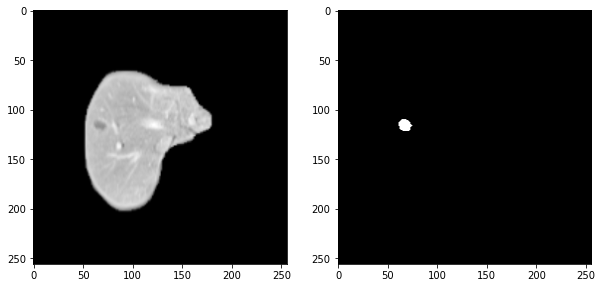

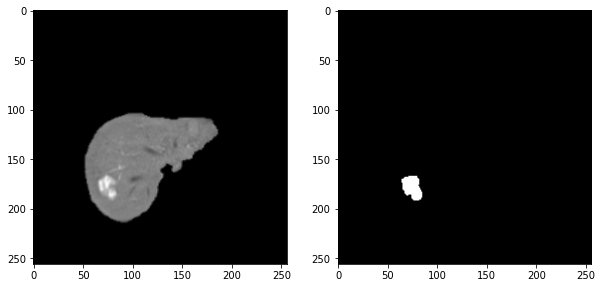

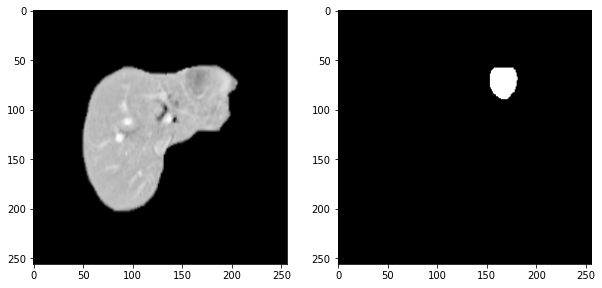

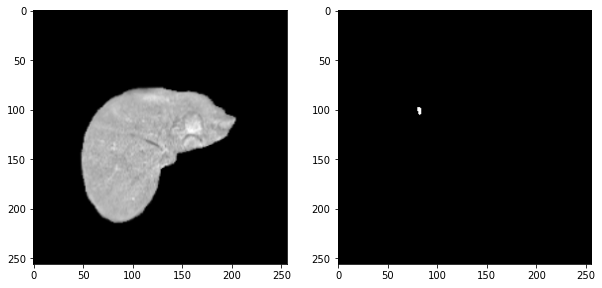

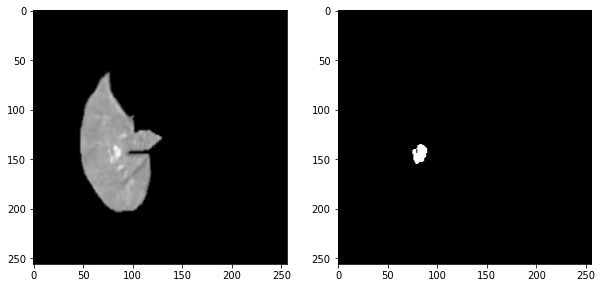

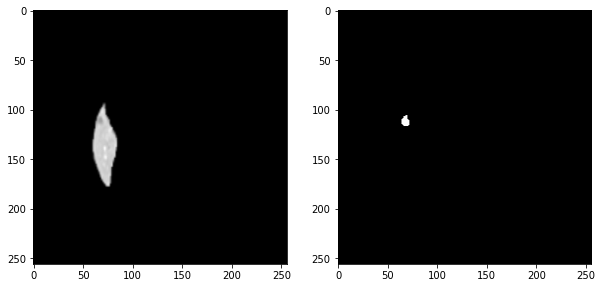

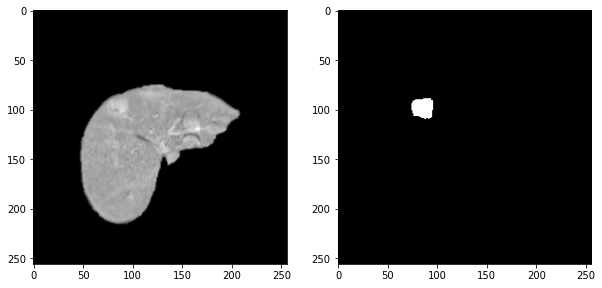

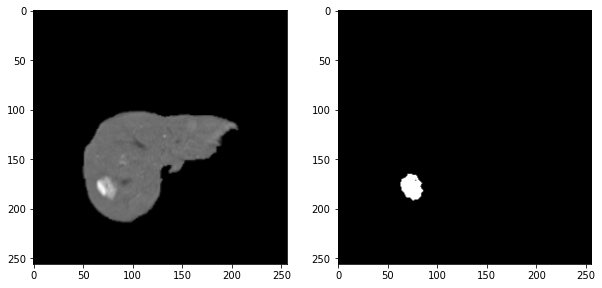

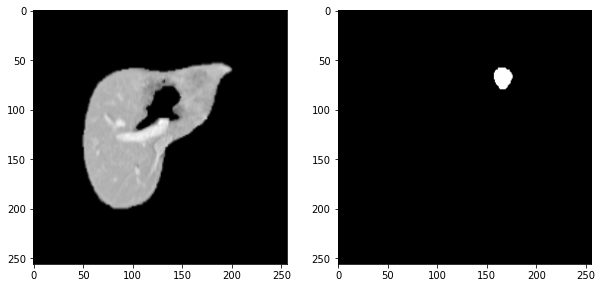

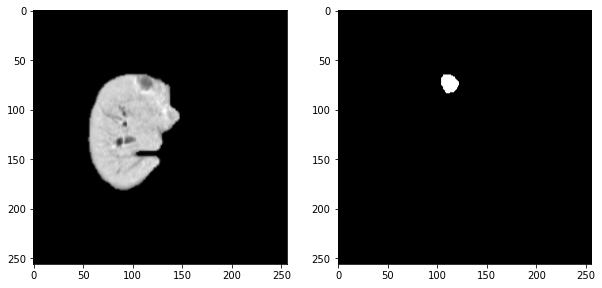

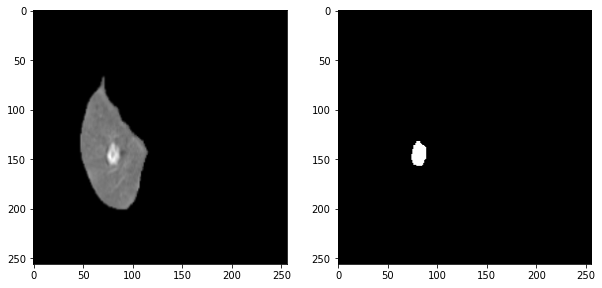

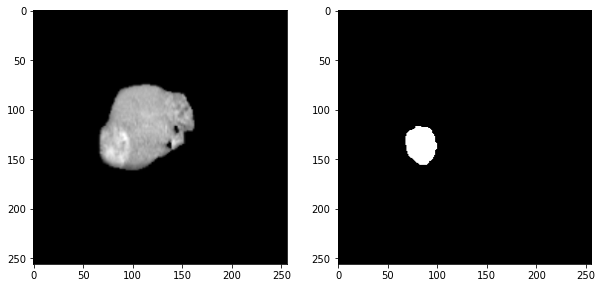

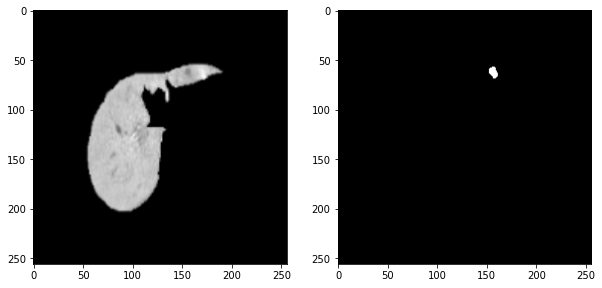

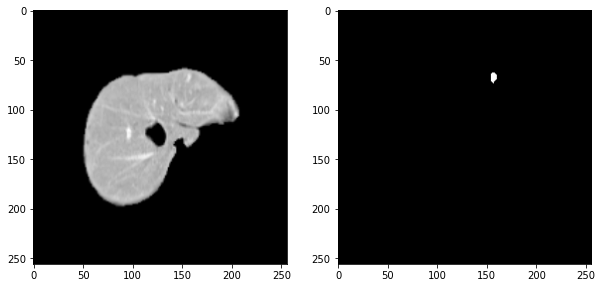

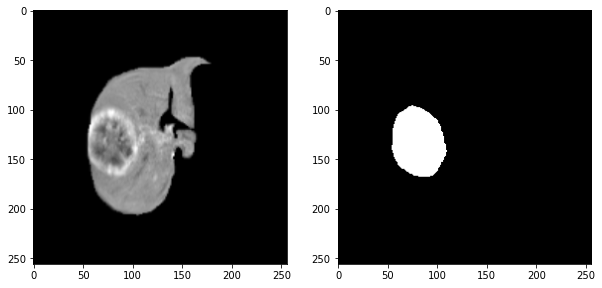

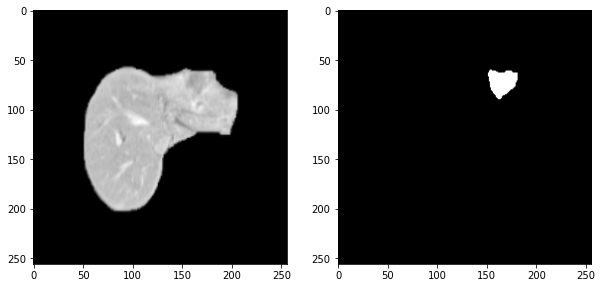

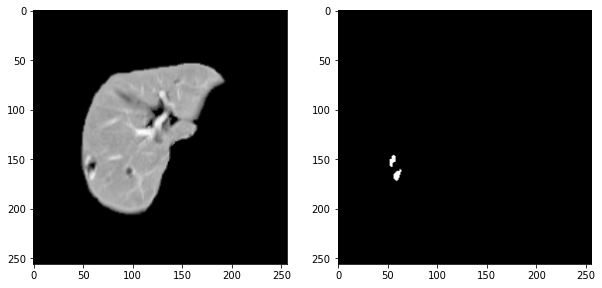

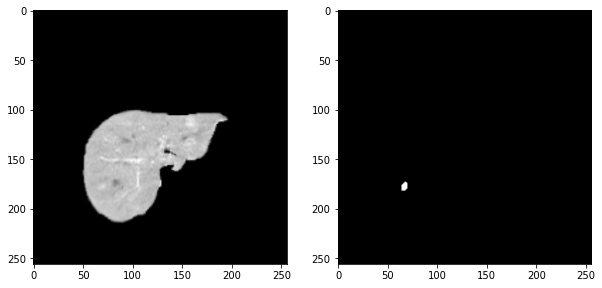

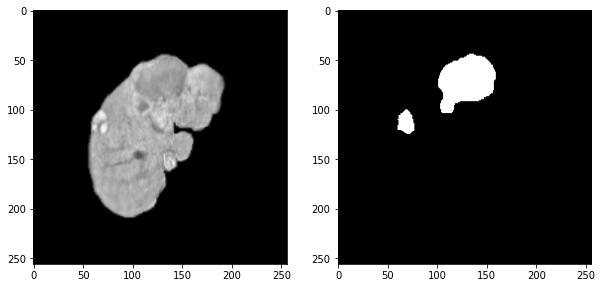

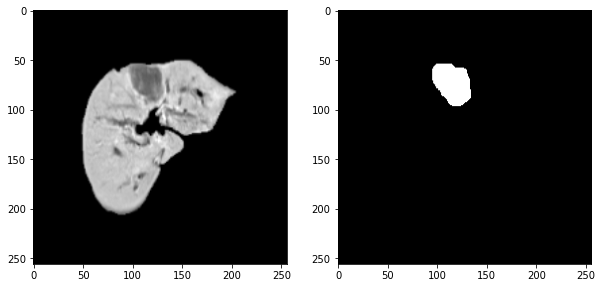

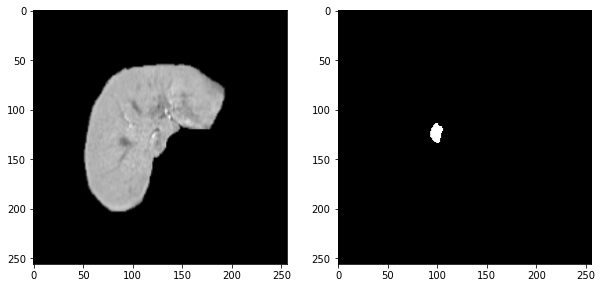

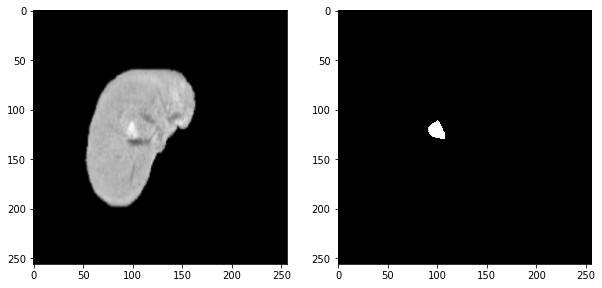

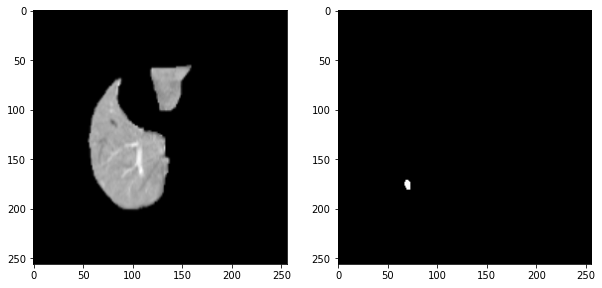

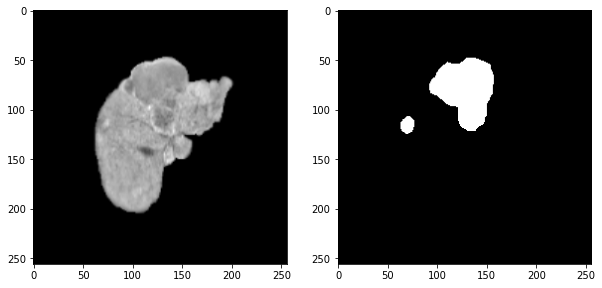

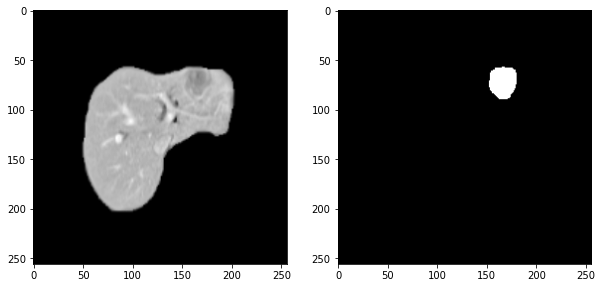

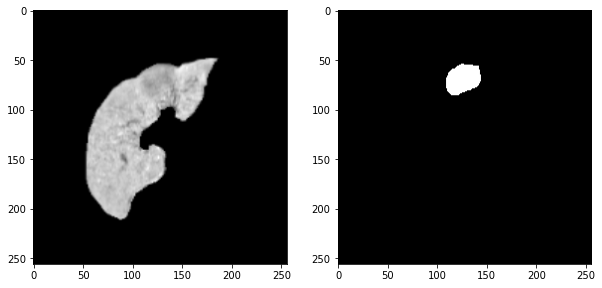

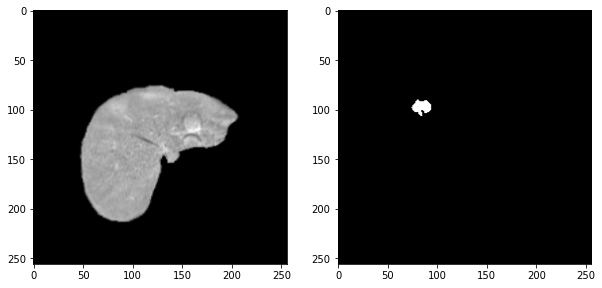

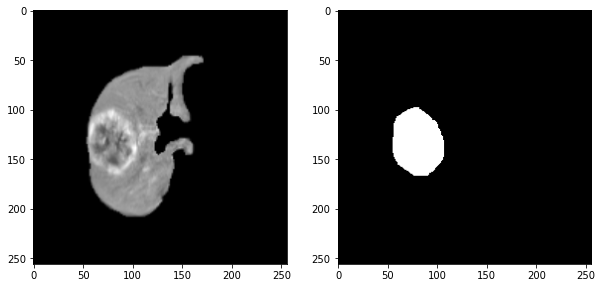

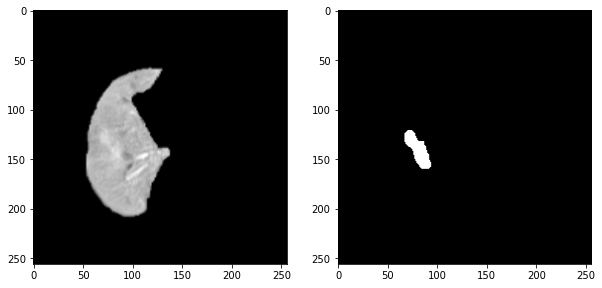

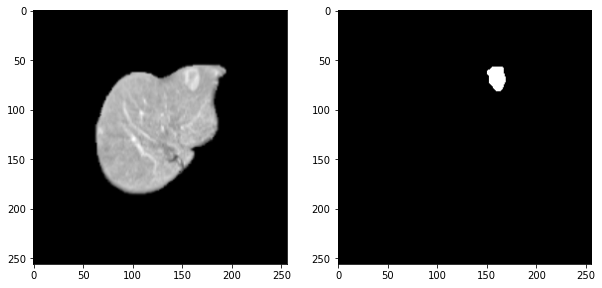

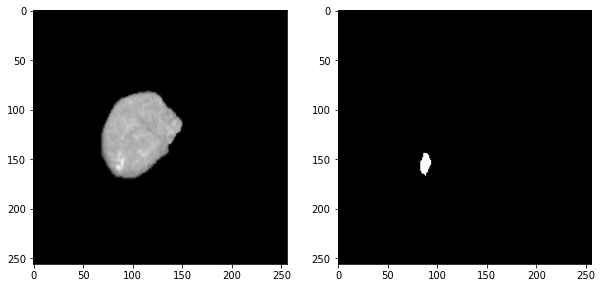

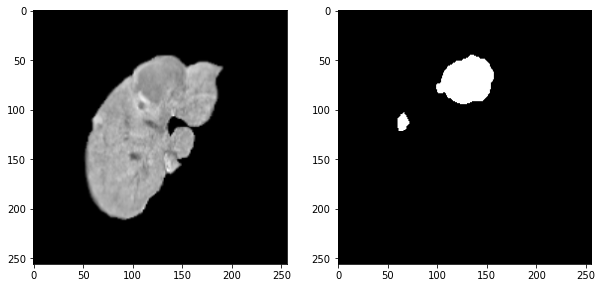

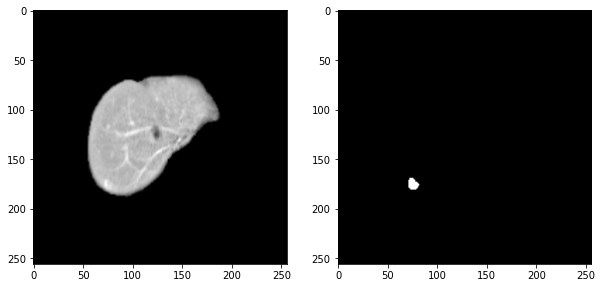

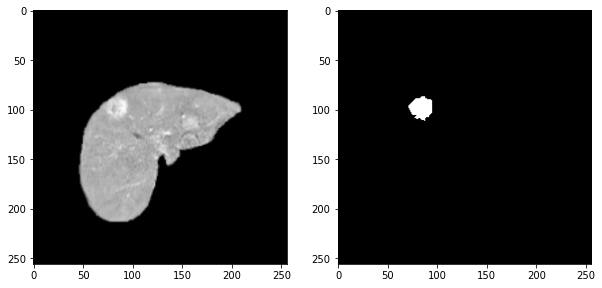

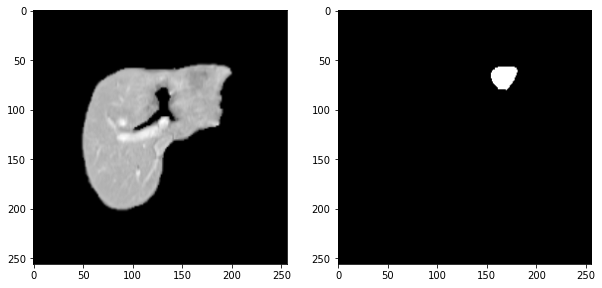

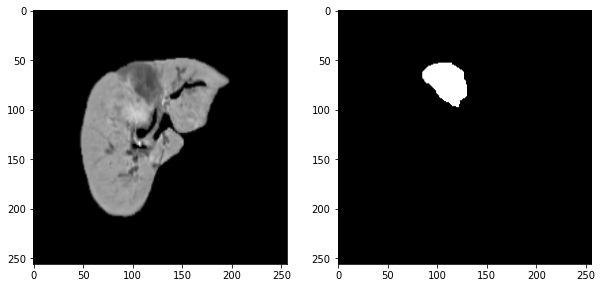

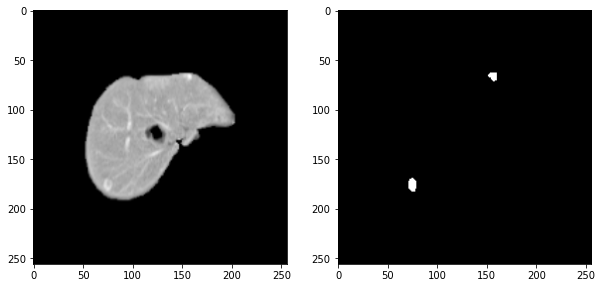

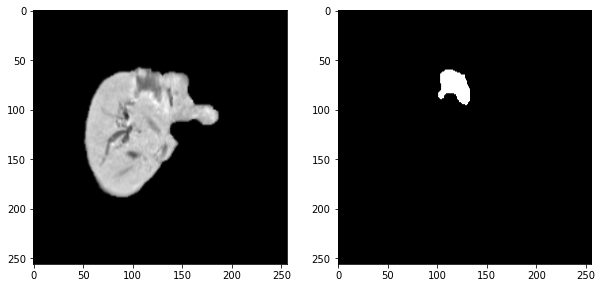

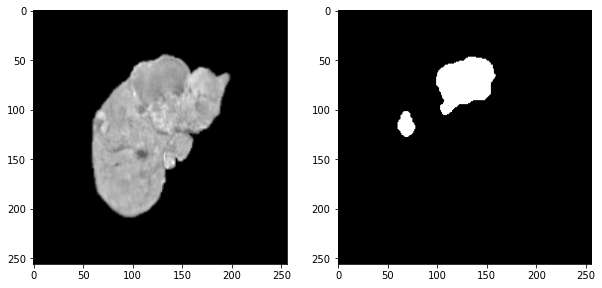

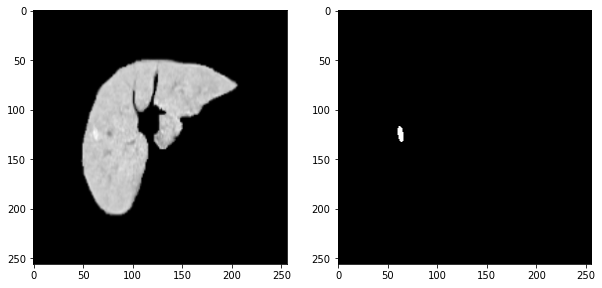

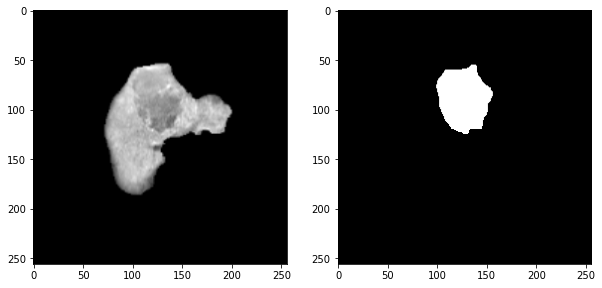

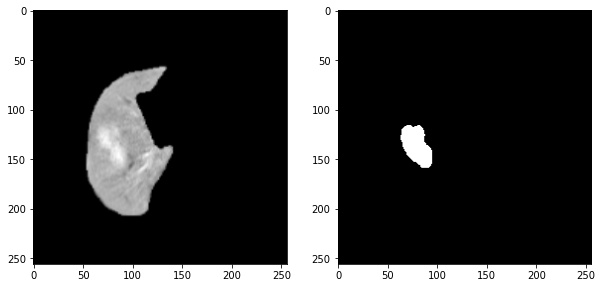

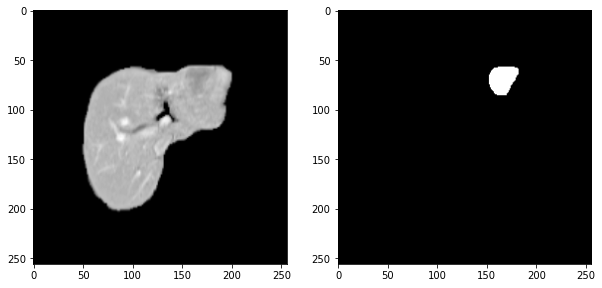

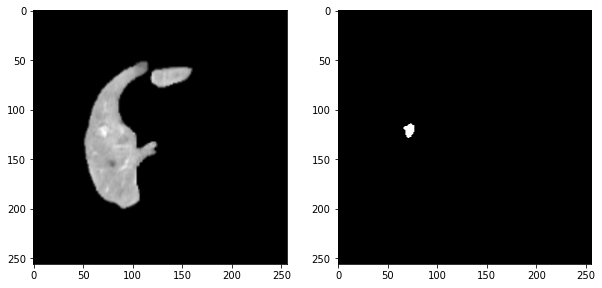

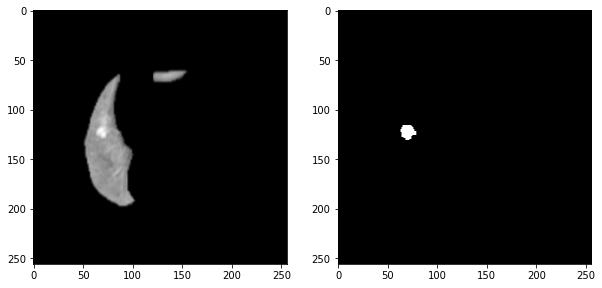

In [ ]:
for i in range(test_p.shape[0]):
  imshow(test_p[i,:,:,0],test_mask_p[i,:,:,0])

#Build metrics and Unet architecture

In [ ]:
smooth = 1.
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

def relative_volumne_difference(y_true,y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  return (K.sum(y_pred) - K.sum(y_true))/K.sum(y_true)

def vol_overlap_err(y_true, y_pred):
    return 1 - jaccard_index(y_true,y_pred)

def jaccard_index(y_true,y_pred):
  return (dice_coef(y_true,y_pred))/ (2 - dice_coef(y_true,y_pred))

alpha = 0.6
def custom_loss(y_true,y_pred):
  return (1 - alpha) * dice_coef_loss(y_true, y_pred) + alpha * vol_overlap_err(y_true, y_pred)

def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))  

def get_unet():
  inputs = Input(shape = (256,256,1))
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  
  dropconv4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(dropconv4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  dropconv5 = Dropout(0.5)(conv5)

  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(dropconv5), conv4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
  

  
  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
  
  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
  
  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
  

  
  conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

  model = Model(inputs=inputs, outputs=[conv10])

  model.compile(optimizer=Adam(lr=0.00001), loss=dice_coef_loss, metrics=[dice_coef,tf.keras.metrics.MeanIoU(num_classes=2)])

  return model
def get_unet_BN():
  inputs = Input(shape = (256,256,1))
  conv1 = Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(inputs)
  conv1 = BatchNormalization(axis=3)(conv1)
  conv1 = Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv1)
  conv1 = BatchNormalization(axis=3)(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(pool1)
  conv2 = BatchNormalization(axis=3)(conv2)
  conv2 = Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv2)
  conv2 = BatchNormalization(axis=3)(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(pool2)
  conv3 = BatchNormalization(axis=3)(conv3)
  conv3 = Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv3)
  conv3 = BatchNormalization(axis=3)(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(256, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(pool3)
  conv4 = BatchNormalization(axis=3)(conv4)
  conv4 = Conv2D(256, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv4)
  conv4 = BatchNormalization(axis=3)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  pool4 = Dropout(0.5)(pool4)

  conv5 = Conv2D(512, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(pool4)
  conv5 = BatchNormalization(axis=3)(conv5)
  conv5 = Conv2D(512, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv5)
  conv5 = BatchNormalization(axis=3)(conv5)
  conv5 = Dropout(0.5)(conv5)
  
  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2),use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv5), conv4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(up6)
  conv6 = BatchNormalization(axis=3)(conv6)
  conv6 = Conv2D(256, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv6)
  conv6 = BatchNormalization(axis=3)(conv6)

 
  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2),use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(up7)
  conv7 = BatchNormalization(axis=3)(conv7)
  conv7 = Conv2D(128, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv7)
  conv7 = BatchNormalization(axis=3)(conv7)

  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2),use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(up8)
  conv8 = BatchNormalization(axis=3)(conv8)
  conv8 = Conv2D(64, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv8)
  conv8 = BatchNormalization(axis=3)(conv8)

  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2),use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(up9)
  
  conv9 = BatchNormalization(axis=3)(conv9)
  conv9 = Conv2D(32, (3, 3), activation='relu',use_bias=True, kernel_initializer='glorot_uniform', padding='same')(conv9)
  conv9 = BatchNormalization(axis=3)(conv9)
  conv9 = Dropout(0.5)(conv9)
  conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

  model = Model(inputs=inputs, outputs=[conv10])

  model.compile(optimizer=Adam(lr=0.0001), loss=binary_crossentropy, metrics=[dice_coef,tf.keras.metrics.MeanIoU(num_classes=2),relative_volumne_difference])
  # model.compile(optimizer=Adam(lr=0.0001), loss=dice_coef_loss, metrics=[dice_coef])
  return model

In [ ]:
# noise_mask = normalization_mask(noise_mask)
# new_label = normalization_mask(new_label)

In [ ]:
batch_size = 1
print(train_p.shape)

def Unet(img_p,slice_mask,img_test_p,slice_test_mask):
    warnings.filterwarnings("ignore")
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    early_stoping = EarlyStopping(monitor='val_dice_coef', patience=15, verbose=1,mode='max')
    model_checkpoint = ModelCheckpoint('./Liver Weights Model/weights_tumor_unet_1.h5', monitor='val_dice_coef', save_best_only=True,verbose=1 ,mode = 'max')
    reduce_lr = ReduceLROnPlateau(monitor = 'val_dice_coef', factor = 0.3, patience = 5,min_lr=1e-5, verbose=1,mode='max')
    #Saving the weights and the loss of the best predictions we obtained
    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    # model.summary()
    csv_logger = CSVLogger('./Liver Weights Model/tumors_log_unet_1.log', separator=',', append=False)

    history = model.fit(img_p, slice_mask, batch_size=batch_size, epochs=300, verbose=1, shuffle=True,
                      # validation_split = 0.3,
                      validation_data = (img_test_p,slice_test_mask),
            # callbacks=[model_checkpoint,early_stoping]
            callbacks=[model_checkpoint,csv_logger,reduce_lr,early_stoping]
            )
    
    return history

(1785, 256, 256, 1)


In [ ]:
history = Unet(train_p,train_mask_p,test_p,test_mask_p)

------------------------------
Creating and compiling model...
------------------------------
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

------------------------------
Fitting model...
------------------------------

Train on 1785 samples, validate on 45 samples
Epoch 1/300
1785/1785 [==============================] - 50s 28ms/step - loss: 0.8244 - dice_coef: 0.1756 - mean_io_u: 0.4937 - val_loss: 0.8052 - val_dice_coef: 0.1948 - val_mean_io_u: 0.4983

Epoch 00001: val_dice_coef improved from -inf to 0.19481, saving model to ./Liver Weights Model/weights_tumor_unet_1.h5
Epoch 2/300
1785/1785 [==============================] - 42s 24ms/step - loss: 0.7413 - dice_coef: 0.2587 - mean_io_u: 0.4979 - val_loss: 0.8388 - val_dice_coef: 0.1612 - val_mean_io_u: 0.4974

Epoch 00002: val_dice_coef did not improve from 0.19481
Epoch 3/300
1785/1785 [==============================] - 42s 24ms/step - loss: 0.7092 - dice_coef: 0.2908 - mean_io_u: 0.4973 - val_lo

In [ ]:
batch_size = 6
def BN_Unet(image_train,label_train,image_test, label_test):
    warnings.filterwarnings("ignore")
    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet_BN()
    early_stoping = EarlyStopping(monitor='val_dice_coef', patience=15, verbose=1,mode='max')
    model_checkpoint = ModelCheckpoint('./Liver Weights Model/weights_tumor_unet_2.h5', monitor='val_dice_coef', save_best_only=True,verbose=1 ,mode = 'max')
    #Saving the weights and the loss of the best predictions we obtained
    reduce_lr = ReduceLROnPlateau(monitor = 'val_dice_coef', factor = 0.3, patience = 5,min_lr=1e-5, verbose=1,mode='max')

    print('-'*30)
    print('Fitting model...')
    print('-'*30)
    csv_logger = CSVLogger('./Liver Weights Model/tumors_log_unet_2.log', separator=',', append=False)
    history = model.fit(image_train,label_train, batch_size=batch_size, epochs=300, verbose=1, shuffle=True,
                      # validation_split = 0.3,
                      validation_data = (image_test, label_test),
            # callbacks=[model_checkpoint,early_stoping]
            callbacks=[model_checkpoint,csv_logger,reduce_lr,early_stoping]
            )
    
    return history

In [ ]:
# dice_coef,f1_m
history_2 = BN_Unet(train_p,train_mask_p,test_p,test_mask_p)

------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Train on 1768 samples, validate on 45 samples
Epoch 1/300
1768/1768 [==============================] - 39s 22ms/step - loss: 0.6504 - dice_coef: 0.0841 - mean_io_u_22: 0.4902 - relative_volumne_difference: 26.3516 - val_loss: 0.5063 - val_dice_coef: 0.0253 - val_mean_io_u_22: 0.5103 - val_relative_volumne_difference: 47.0475

Epoch 00001: val_dice_coef improved from -inf to 0.02533, saving model to ./Liver Weights Model/weights_tumor_unet_2.h5
Epoch 2/300
1768/1768 [==============================] - 31s 18ms/step - loss: 0.4775 - dice_coef: 0.1130 - mean_io_u_22: 0.5335 - relative_volumne_difference: 20.9448 - val_loss: 0.4388 - val_dice_coef: 0.0513 - val_mean_io_u_22: 0.5522 - val_relative_volumne_difference: 37.3613

Epoch 00002: val_dice_coef improved from 0.02533 to 0.05135, saving model to ./Liver Weights Mode

In [ ]:
print('-'*30)
print('Loading saved weights...')
print('-'*30)
load_model = get_unet()
load_model_2 = get_unet_BN()
load_model.load_weights('./Liver Weights Model/weights_tumor_unet_1.h5')
load_model_2.load_weights('./Liver Weights Model/weights_tumor_unet_2.h5')

------------------------------
Loading saved weights...
------------------------------


In [ ]:
print('-'*30)
print('Predicting masks on test data...')
print('-'*30)
tumor_predict = load_model.predict(test_x,verbose=1,batch_size=1)
tumor_predict_2 = load_model_2.predict(test_x, verbose=1,batch_size=1)

------------------------------
Predicting masks on test data...
------------------------------
160/160 [==============================] - 10s 59ms/step


In [ ]:
test_y = normalization_mask(test_y)

8904


In [ ]:
tumor_predict = normalization_mask(tumor_predict)
tumor_predict_2 = normalization_mask(tumor_predict_2)

11475
7690


In [ ]:
dice = np.sum(tumor_predict[test_y==1])*2.0 / (np.sum(tumor_predict) + np.sum(test_y))
dice

0.6316306001275823

In [ ]:
dice = np.sum(tumor_predict_2[test_y==1])*2.0 / (np.sum(tumor_predict_2) + np.sum(test_y))
dice

0.6691575268169218

In [ ]:
for i in range(test_x.shape[0]):
  print("slice",i)
  imshow(test_x[i,:,:,0],tumor_predict_2[i,:,:,0],test_y[i,:,:,0])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from skimage.segmentation import mark_boundaries

# boundaries_test = []
# for i in range(tumor_test.shape[0]):
#   boundaries_test.append(mark_boundaries(test_x[i,:,:,0],tumor_test[i,:,:,0],color=(255,0,0)))
# for i in range(boundaries_test.shape[0]):
#   imshow(boundaries_test[i])
a = mark_boundaries(test_x[144,:,:,0],tumor_test[144,:,:,0],color=(255,0,0))


In [ ]:
imshow((a*130).astype(np.uint8))

In [ ]:
imshow(a.astype(np.uint8))